In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
import docx
from dataclasses import dataclass
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.spatial.distance import cdist
from shutil import move
from sklearn.decomposition import NMF
import math
import pandas as pd
from scipy.spatial.distance import cosine
import heapq
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
source_dir = "./test_documents"
# read every document file with docx.Document in current directory

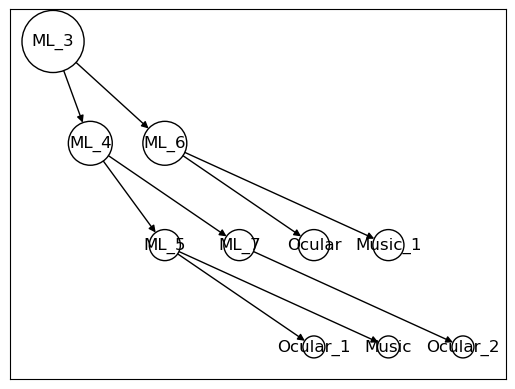

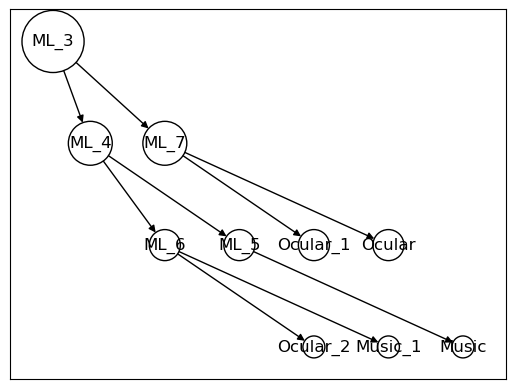

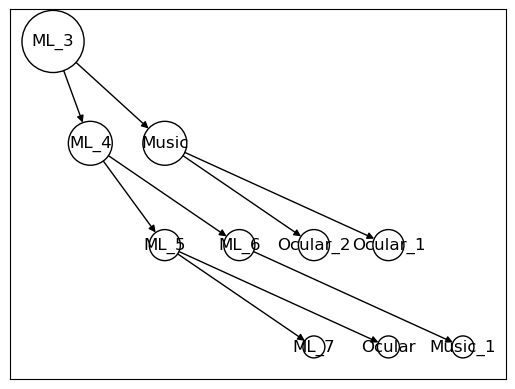

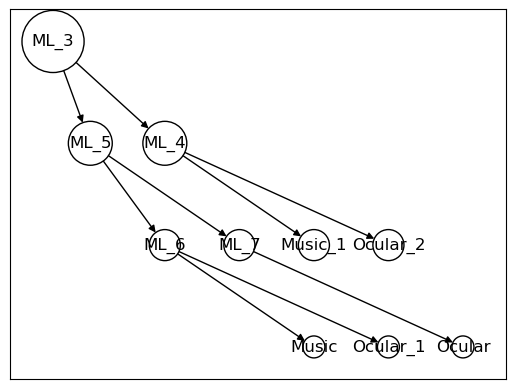

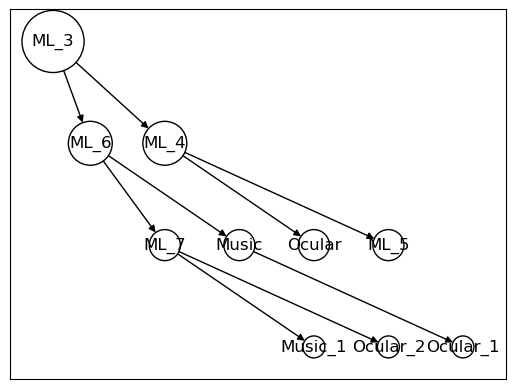

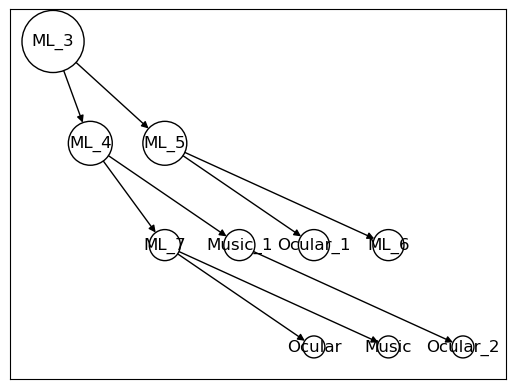

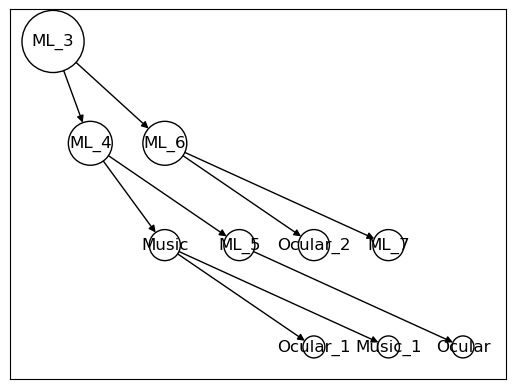

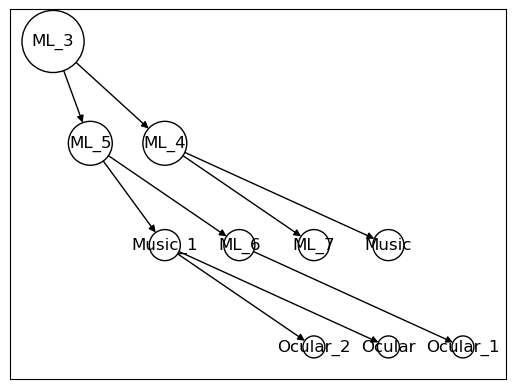

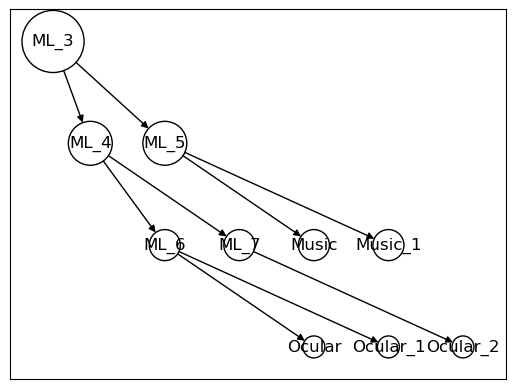

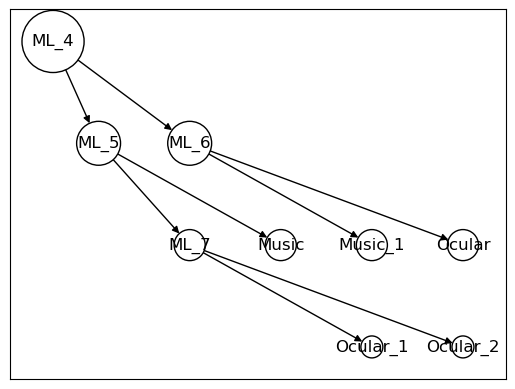

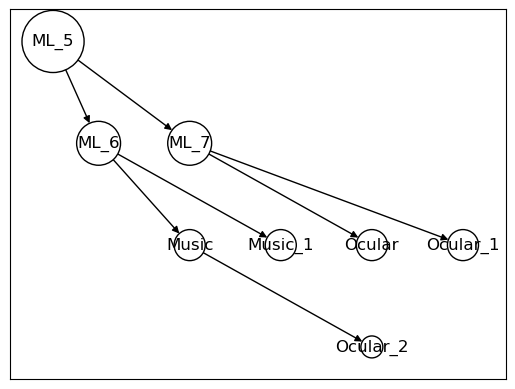

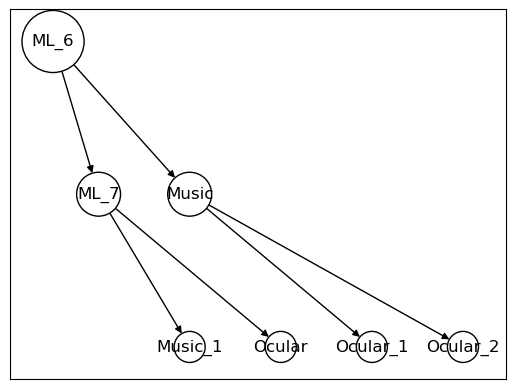

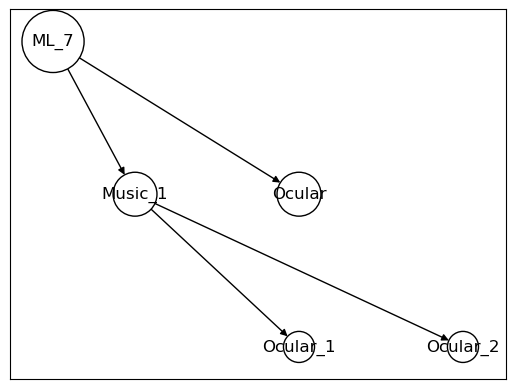

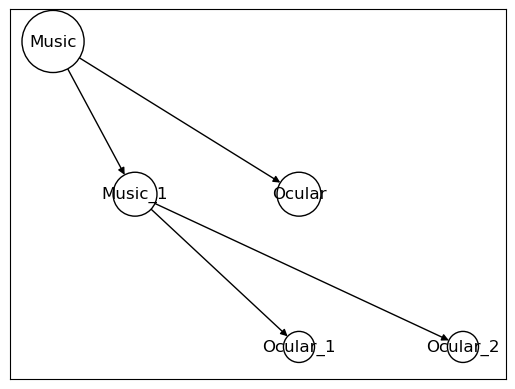

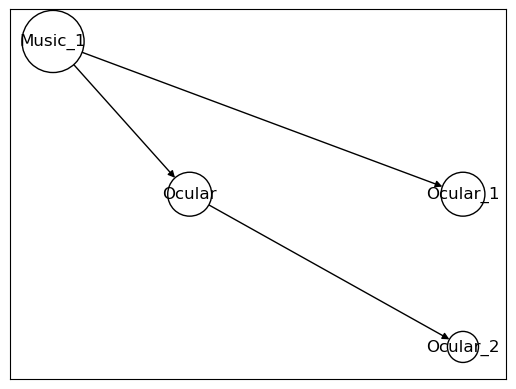

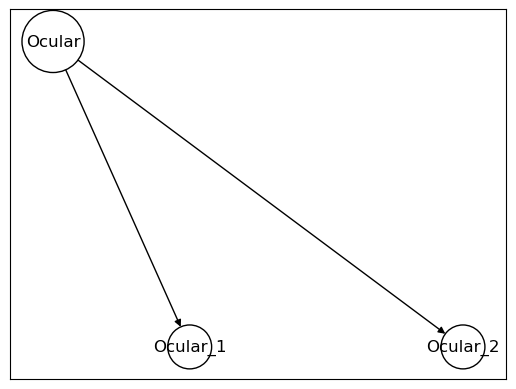

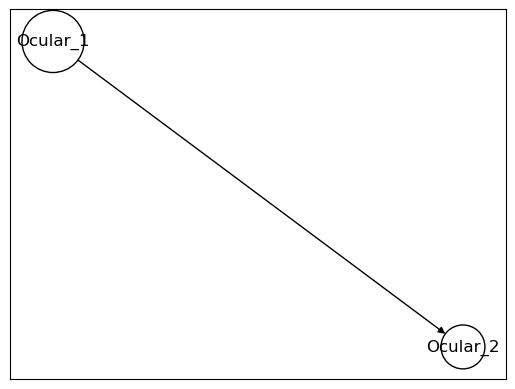

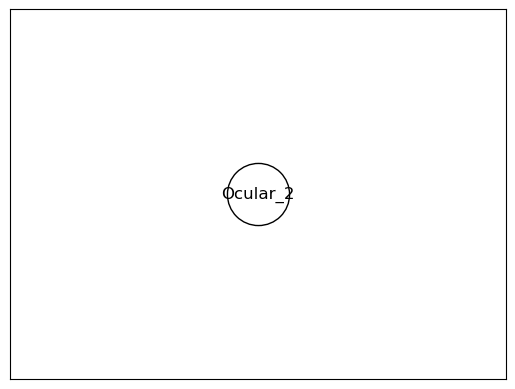

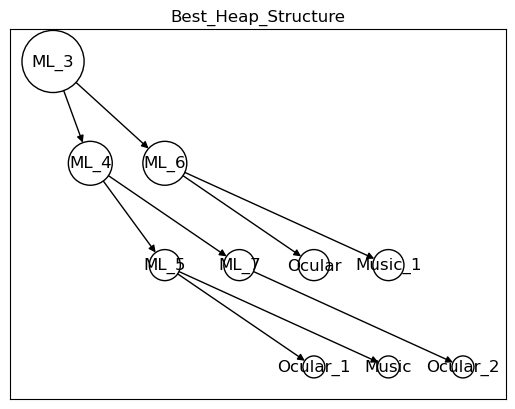

Inertia: 12.522267651951502
{'ML_5.docx': 0, 'Ocular.docx': 1, 'Ocular_2.docx': 1, 'ML_4.docx': 1, 'Business.docx': 1, 'Music_1.docx': 1, 'ML_3.docx': 0, 'Business_1.docx': 0, 'ML_2.docx': 3, 'Music.docx': 3, 'Business_2.docx': 3, 'ML_1.docx': 3, 'Business_3.docx': 0, 'Business_4.docx': 2, 'Biology.docx': 2, 'ML_7.docx': 0, 'Ocular_1.docx': 0, 'ML_6.docx': 0}


In [4]:
@dataclass
class document_clf:
    def __init__(self, source_dir):
        self.source_dir = source_dir
        self.docx_dir = ""
        self.stop_words = set(stopwords.words('english'))
        self.inverse_doc_frequency = defaultdict(int)
        self.tf_idf_matrix = []
        self.tf_idf_vectors = []

    def read_docx_tf_idf(self, source_dir):
        """Read docx files from a given directory and extract their text content then changes them into tf_idf_matrix."""
        # Get a list of all docx files in the source directory
        docx_files = sorted(os.listdir(source_dir))

        # Initialize empty lists to store the document text and tokenized text
        doc_lst = []
        token_lst = []

        # Loop through each file in the directory and extract its text content
        for file_name in docx_files:
            if file_name.endswith(".docx"):
                # Get the full path of the file
                file_path = self.source_dir + '/' + file_name

                # Open the docx file and extract its text content
                doc = docx.Document(file_path)
                fullText = []
                for para in doc.paragraphs:
                    fullText.append(para.text)
                mystring =  '\n'.join(fullText)

                # Tokenize the text content and remove stop words and non-alphabetic words
                tokens = word_tokenize(mystring)
                tokens = [w for w in tokens if not w in self.stop_words]
                tokens = [word.lower() for word in tokens if word.isalpha()]

                # Add the tokenized text to the list of tokenized texts
                token_lst.append(tokens)

                # Join the tokens back into a string and add it to the list of document text
                doc_string = ' '.join(tokens)
                doc_lst.append(doc_string)

        # Return the list of document text
        vectorizer = TfidfVectorizer()
        tf_idf_vectors = vectorizer.fit_transform(doc_lst)
        tf_idf_matrix = tf_idf_vectors.toarray()
        
        return doc_lst,tf_idf_matrix, tf_idf_vectors
    
    def create_tf_idf_matrix(self):
        """Run read_docx_tf_idf and store tf_idf_matrix"""
        self.doc_lst,self.tf_idf_matrix, self.tf_idf_vectors = self.read_docx_tf_idf(self.source_dir)

    def elbow_method_K(self, num_of_clusters):

        # Initialize lists and mappings for distortions and inertias
        distortions = []
        inertias = []
        mapping1 = {}
        mapping2 = {}

        # Define range of k-values
        K = range(1, num_of_clusters + 1)

        # Loop through each value of k and fit the model
        for k in K:
            kmeanModel = KMeans(n_clusters=k).fit(self.tf_idf_matrix)
            kmeanModel.fit(self.tf_idf_matrix)

            # Calculate distortions and inertias and store in lists
            distortions.append(sum(np.min(cdist(self.tf_idf_matrix, kmeanModel.cluster_centers_,
                                                'euclidean'), axis=1)) / len(self.tf_idf_matrix[0]))
            inertias.append(kmeanModel.inertia_)

            # Store distortions and inertias in mappings
            mapping1[k] = sum(np.min(cdist(self.tf_idf_matrix, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / len(self.tf_idf_matrix[0])
            mapping2[k] = kmeanModel.inertia_

        # Print out the distortions for each value of k
        for key, val in mapping1.items():
            print(f'{key} : {val}')

        # Plot the elbow curve
        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.show()

    def K_means_cluster(self):
        doc_lst,tf_idf_matrix,tf_idf_vectors = self.read_docx_tf_idf(self.source_dir)
        # after finding the best number of clusters, use K-means clustering
        kmeans = KMeans(n_clusters=4, random_state=23)
        kmeans.fit(tf_idf_matrix)
        cluster_labels = kmeans.predict(tf_idf_matrix)
        
        # Assign cluster labels to each document
        docx_files = os.listdir(source_dir)
        doc_lst = []
        for file_name in docx_files:
            if file_name.endswith(".docx"):
                doc_lst.append(file_name)

        doc_label_dict = dict()
        for i in range(len(doc_lst)):
            # Assign labels to each document based on cluster labels
            doc_label_dict[doc_lst[i]] = cluster_labels[i]
        inertia = kmeans.inertia_
        print(f"Inertia: {inertia}")
        return doc_label_dict
    
    
    def create_heap(self):
        doc_lst,tf_idf_matrix,tf_idf_vectors = self.read_docx_tf_idf(self.source_dir)

        file_name_lst = sorted(os.listdir(self.source_dir))
        file_name_lst = [i for i in file_name_lst if i.endswith(".docx")]

        # Have a list of numbers in range of 0 to total number of documents
        # Then make heap data structure based on every root untill every document has been covered
        num_lst = [i for i in range(len(doc_lst))]

        # Set the number of most similar documents to return
        k = 10
        # Set a threshold for cosine similarity
        threshold = 0.01

        file_name_set=set()
        
        # array to store document numbers stored by heap
        heap_num_covered = []
        j = 0
        counter = 0
        best_heap = None
        best_heap_num_covered = 0
        while j < len(doc_lst):
            # Initialize a heap data structure with the first document
            # heap will generate relevant document according to the root document
            file_name_lst2 = file_name_lst[j:len(doc_lst)]
            heap = [(1, tf_idf_vectors[j], 1, file_name_lst2[0])]

            # Loop through each subsequent document
            for i in range(j+1, tf_idf_vectors.shape[0]):
                # Calculate cosine similarity between the new document and each document currently in the heap
                cosine_similarities = [1 - cosine(heap_item[1].toarray()[0], tf_idf_vectors[i].toarray()[0]) for heap_item in heap]

                # Check if the cosine similarity between the new document and any document in the heap is greater than the threshold value
                if max(cosine_similarities) >= threshold:
                    # Add the new document to the heap
                    heap_item = (i + 1, tf_idf_vectors[i], max(cosine_similarities), file_name_lst2[i-j])
                    heapq.heappush(heap, heap_item)

                    # Remove the document with the lowest cosine similarity if the heap is full
                    if len(heap) > k:
                        heapq.heappop(heap)

            # check if this heap has more covered documents than the current best heap
            if len(heap) > best_heap_num_covered:
                best_heap = heap
                best_heap_num_covered = len(heap)

            j += 1
            
            G = nx.DiGraph()
            # add nodes to the graph
            for i,val in enumerate(heap):
                G.add_node(i)
            
            # set labels of nodes to the corresponding file names
            labels = {i: val[3].replace('.docx', '') for i, val in enumerate(heap)}
            
            for i in range(len(heap)):
                if 2*i+1 < len(heap):
                    G.add_edge(i, 2*i+1)
                if 2*i+2 < len(heap):
                    G.add_edge(i, 2*i+2)
            
            # Set the node size and position for a pyramid-like visualization
            pos = {}
            node_size = []
            

                
            for i in range(len(heap)):
                depth = len(bin(i+1))-3  # calculate the depth of the node in the heap
                x_pos = i - 2**(depth-1)  # calculate the x-position of the node
                y_pos = -depth  # calculate the y-position of the node
                pos[i] = (x_pos, y_pos)
                node_size.append(1000/(2**(depth-1)))
                
                


            # Draw the heap
            nx.draw_networkx(G, pos=pos, node_size=node_size, font_size=12, node_color='w', edgecolors='k', linewidths=1, labels=labels)
            plt.savefig(f'heap_{counter}.png')
            plt.show()
            counter += 1
        return best_heap
    
    def draw_best_heap(self,best_heap):
        # draw the best heap
        if best_heap is not None:
            G = nx.DiGraph()
            # add nodes to the graph
            for i,val in enumerate(best_heap):
                G.add_node(i)

            # set labels of nodes to the corresponding file names
            labels = {i: val[3].replace('.docx', '') for i, val in enumerate(best_heap)}

            for i in range(len(best_heap)):
                if 2*i+1 < len(best_heap):
                    G.add_edge(i, 2*i+1)
                if 2*i+2 < len(best_heap):
                    G.add_edge(i, 2*i+2)

            # Set the node size and position for a pyramid-like visualization
            pos = {}
            node_size = []

            for i in range(len(best_heap)):
                depth = len(bin(i+1))-3  # calculate the depth of the node in the heap
                x_pos = i - 2**(depth-1)  # calculate the x-position of the node
                y_pos = -depth  # calculate the y-position of the node
                pos[i] = (x_pos, y_pos)
                node_size.append(1000/(2**(depth-1)))

            # Draw the heap
            nx.draw_networkx(G, pos=pos, node_size=node_size, font_size=12, node_color='w', edgecolors='k', linewidths=1, labels=labels)
            plt.title("Best_Heap_Structure")
            plt.savefig(f'best_heap.png')
            plt.show();

cluster_object = document_clf(source_dir)
# Need to run .create_tf_idf_matrix() to have the matrix available for other functions
cluster_object.read_docx_tf_idf(source_dir)
best_heap = cluster_object.create_heap()

cluster_object.draw_best_heap(best_heap)
print(cluster_object.K_means_cluster())

